https://kiwidamien.github.io/are-you-sure-thats-a-probability.html

- Calibration Curve

In [1]:
%%latex
\tableofcontents

<IPython.core.display.Latex object>

# Setup

## Import Libraries

In [2]:
print ('Install Packages')

import sys, copy, math, time, os

print ('Python version: {}'.format(sys.version))

#from collections import Counter

import numpy as np
print ('NumPy version: {}'.format(np.__version__))
np.set_printoptions(suppress=True)

import scipy as sc
print ('SciPy version:  {}'.format(sc.__version__))

import tensorflow as tf
print ('TensorFlow version:  {}'.format(tf.__version__))
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

from tensorflow import keras
print ('Keras version:  {}'.format(keras.__version__))

from keras import layers
import keras.backend as K
from keras.layers import IntegerLookup
from keras.layers import Normalization
from keras.layers import StringLookup
from keras.utils import get_custom_objects
from keras.utils import tf_utils

from keras.models import Sequential
from keras.layers import Dense

#from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

import pandas as pd
print ('Pandas version:  {}'.format(pd.__version__))
pd.set_option('display.max_rows', 500)

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

import matplotlib.pyplot as plt
%matplotlib inline

# Library for reading Microsoft Access files
#import pandas_access as mdb

import sklearn
print ('SciKit-Learn version: {}'.format(sklearn.__version__))
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

import imblearn
print ('Imbalanced-Learn version: {}'.format(imblearn.__version__))
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier

#!pip install pydot

# Set Randomness.  Copied from https://www.kaggle.com/code/abazdyrev/keras-nn-focal-loss-experiments
import random
#np.random.seed(42) # NumPy
#random.seed(42) # Python
#tf.random.set_seed(42) # Tensorflow

import warnings
warnings.filterwarnings('ignore')

print ('Finished Installing Packages')

Install Packages
Python version: 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
NumPy version: 1.24.2
SciPy version:  1.7.3


/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow version:  2.11.0
Keras version:  2.11.0
Pandas version:  1.5.3
SciKit-Learn version: 1.2.2
Imbalanced-Learn version: 0.10.1
Finished Installing Packages


In [3]:
rain = pd.read_csv('seattleWeather_1948-2017.csv').dropna()
print (len(rain))
rain.head()


25548


,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


In [4]:
features = rain[['TMIN', 'TMAX']]
target = rain.RAIN.astype(bool)
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)

y_train.mean()

0.42774385470486925

In [5]:
from sklearn.naive_bayes import GaussianNB
nb_rain = GaussianNB().fit(X_train, y_train)
accuracy = nb_rain.score(X_train, y_train)
print(f'The hard predictions were right {100*accuracy:5.2f}% of the time')

The hard predictions were right 67.17% of the time


In [6]:
predictions = nb_rain.predict_proba(X_train)[:, 1]
print (predictions[:10])

[0.00893618 0.5900694  0.06551783 0.68175    0.21330454 0.72545039
 0.05634727 0.49293595 0.29248533 0.72537596]


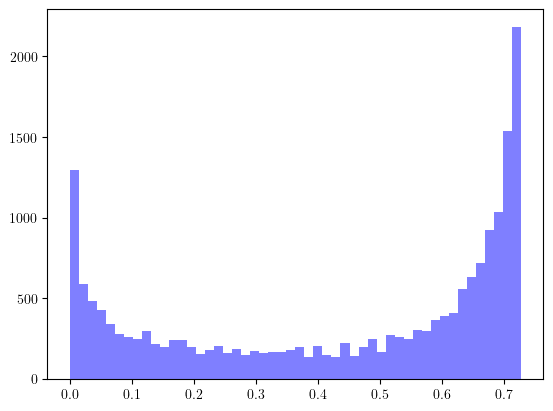

In [7]:
num_bins = 50
n, bins, patches = plt.hist(predictions, num_bins, facecolor='blue', alpha=0.5)
plt.show()

<class 'numpy.ndarray'>


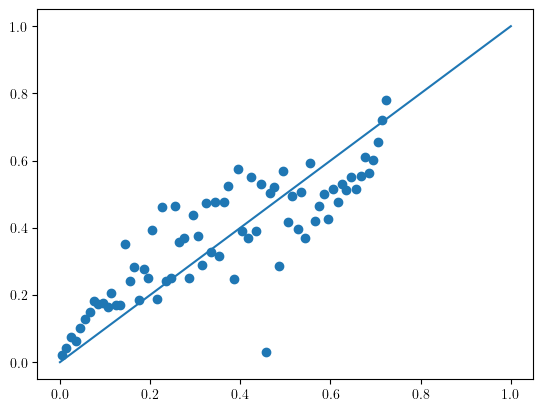

In [8]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

predictions = nb_rain.predict_proba(X_train)[:, 1]
binned_true_p, binned_predict_p = calibration_curve(y_train, predictions, n_bins=100)
print (type(binned_true_p))
#for i in range (len(binned_true_p)):
#    print (binned_true_p[i], binned_predict_p[i])
    
plt.scatter(binned_predict_p, binned_true_p)
plt.plot([0,1],[0,1])
plt.show()

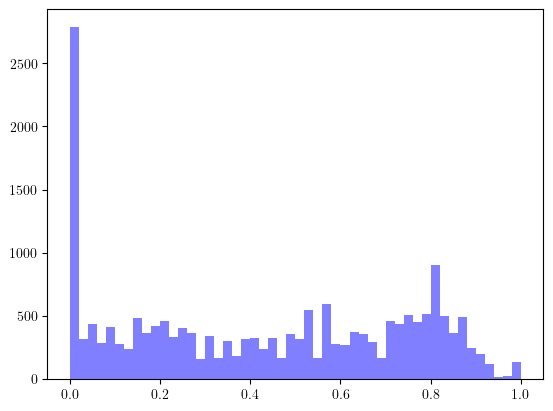

In [9]:
from sklearn.ensemble import RandomForestClassifier
rfc_rain = RandomForestClassifier(n_estimators=100, random_state=13).fit(X_train, y_train)
rfc_predict = rfc_rain.predict_proba(X_train)[:, 1]
num_bins = 50
n, bins, patches = plt.hist(rfc_predict, num_bins, facecolor='blue', alpha=0.5)
plt.show()

<class 'numpy.ndarray'>


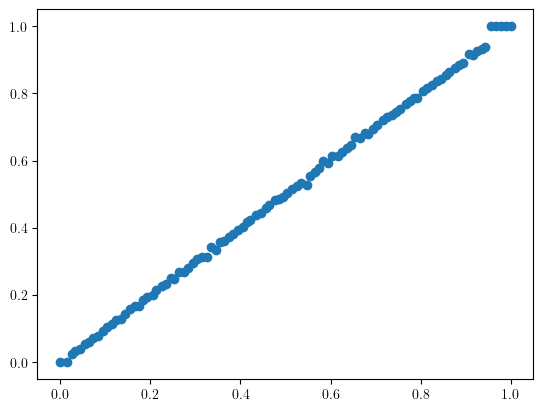

In [10]:
predictions = rfc_rain.predict_proba(X_train)[:, 1]
binned_true_p, binned_predict_p = calibration_curve(y_train, predictions, n_bins=100)
print (type(binned_true_p))
#for i in range (len(binned_true_p)):
#    print (binned_true_p[i], binned_predict_p[i])
    
plt.scatter(binned_predict_p, binned_true_p)
plt.show()

# CalibratedClassifierCV
- Takes the model, nb_rain, and calibrates the model while fitting.

In [11]:
calibrated_nb_rain = CalibratedClassifierCV(nb_rain, cv=5, method='isotonic')
# Note we need to refit!
calibrated_nb_rain.fit(X_train, y_train);

In [12]:
calibrated_probs = calibrated_nb_rain.predict_proba(X_test)[:, 1]
binned_true_p, binned_predict_p = calibration_curve(y_test, calibrated_probs, n_bins=100)

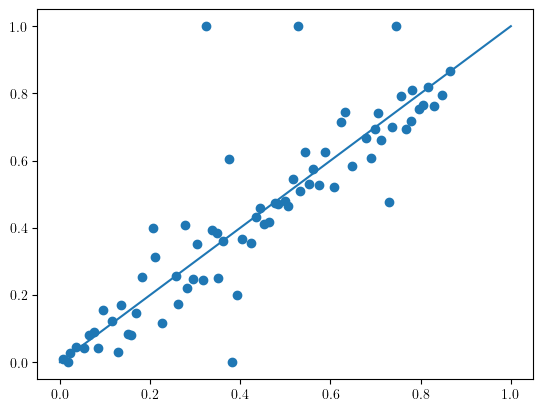

In [13]:
plt.scatter(binned_predict_p, binned_true_p)
plt.plot([0,1],[0,1])
plt.show()